# Run these three cells first:

In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
#!/usr/bin/env python
from __future__ import division
from builtins import str
from builtins import range
from past.utils import old_div
import numpy as np
import datetime
import pickle
from netCDF4 import Dataset
import sys
import matplotlib.pyplot as plt
from chaz import CLE15, utility
from pygplib import readbst
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
from pyproj import Proj, transform
from pygplib3 import landfall as ld
from wind_reconstruct.w_profile_2 import W_profile # from Qidong
from wind_reconstruct.w_profile import W_profile as W_profile_old # from Qidong
import math
import multiprocessing
from joblib import Parallel, delayed
from os import path

In [3]:
# Bounding box for the Philippines
lonmin = 117.17427453
latmin = 5.58100332277
lonmax = 126.537423944
latmax = 18.5052273625

# Indices of bounding box for Philippines
#buffer = 15 # additional space around the Philippines, in indices of the land mask
#lonmini = np.argmin(np.abs(llon-lonmin))-buffer
#lonmaxi = np.argmin(np.abs(llon-lonmax))+buffer
#latmini = np.argmin(np.abs(llat-latmin))+buffer
#latmaxi = np.argmin(np.abs(llat-latmax))-buffer

# Create land mask for just the Philippines
#ldmask_phi = np.zeros(np.shape(ldmask))
#ldmask_phi[latmaxi:latmini+1,lonmini:lonmaxi+1] = ldmask[latmaxi:latmini+1,lonmini:lonmaxi+1]

In [4]:
# File number to examine
fileN = '000'

# Initial subsetting of landfalling TCs over Philippines:

In [5]:
# Load data from file
filename = '/data2/clee/ERAInterim/ERAInterim_wpc_'+fileN+'.nc'
ds0 = xr.open_dataset(filename)
lon = ds0.longitude[:]
lat = ds0.latitude[:]
wspd = ds0.Mwspd[:] # wind speed in knots
days = ds0.time[:] # date in days, 6 hour time steps
days = np.where(days==-54786., np.nan, days)
year = ds0.year[:]

# Load land-sea mask
llon, llat, ldmask = ld.get_landmask('/home/clee/CHAZ/landmask.nc')
land = np.max(ldmask)
ocean = np.min(ldmask)

/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/scipy/io/netcdf.py:317: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


In [6]:
# Interpolate to 15-min timesteps
nscale = 24 # convert from 6-hr to 15-min timesteps (factor of 6*4=24)
lon_int = ld.rescale_matrix(lon,nscale,0) # int for time interpolated 
lat_int = ld.rescale_matrix(lat,nscale,0)
wspd_int = ld.rescale_matrix(wspd,nscale,1)
days_int = ld.rescale_matrix(days,nscale,0)

In [7]:
# Retrieve times of landfall for the WNP
wspd_int_forlandfall = np.nanmax(wspd_int, axis = 0)
iSlandfall = ld.get_landfall_stormID(lon_int,lat_int,wspd_int_forlandfall,llon,llat,ldmask,land,np.min(ldmask))
landfall_times = ld.get_landfall_storm_time(iSlandfall,lon_int,lat_int,wspd_int,llon,llat,ldmask,land,ocean,24)
nSlandfall_first = landfall_times[0] # index of storms that make first landfall (why different than nSlandfall?)
iTlandfall_first = landfall_times[1] # time of making first landfall
nSlandfall_all = landfall_times[2] # index of storms that make any landfall (ie storm would repeat if makes multiple landfalls)
iTlandfall_all = landfall_times[3] # time of making that landfall

/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: All-NaN slice encountered
  


In [8]:
# Select storms making landfall in Philippines
nSlandfall_all_phi = []
iTlandfall_all_phi = []
for j in range(np.shape(nSlandfall_all)[0]):
    nS = nSlandfall_all[j]
    iT = iTlandfall_all[j]
    lon_landfall = lon_int[iT,nS]
    lat_landfall = lat_int[iT,nS]
    if lonmin <= lon_landfall <= lonmax and latmin <= lat_landfall <= latmax:
        nSlandfall_all_phi.append(nSlandfall_all[j])
        iTlandfall_all_phi.append(iTlandfall_all[j])

# Remove duplicate storms (storms that made landfall in Philippines twice)
nSlandfall_phi = list(dict.fromkeys(nSlandfall_all_phi))
    

In [9]:
# Select data only for storms that make landfall in the Philippines
# (for normal timesteps and interpolated timestep data)
lon_phi = lon[:,nSlandfall_phi]
lat_phi = lat[:,nSlandfall_phi]
wspd_phi = wspd[:,:,nSlandfall_phi]
days_phi = days[:,nSlandfall_phi]
year_phi = year[nSlandfall_phi]

lon_int_phi = lon_int[:,nSlandfall_phi]
lat_int_phi = lat_int[:,nSlandfall_phi]
wspd_int_phi = wspd_int[:,:,nSlandfall_phi]
days_int_phi = days_int[:,nSlandfall_phi]

In [10]:
# Save out data of Philippines landfalling TCs
ensN = wspd.ensembleNum.values # count of ensemble numbers

ds = xr.Dataset(
    {"lon": (("iT","nS"), lon_phi),
     "lat": (("iT","nS"), lat_phi),
     "wspd": (("ensembleNum","iT","nS"), wspd_phi), # maximum sustained wind speed in m/s
     "days": (("iT","nS"), days_phi),
     "year": (("nS"), year_phi)},
        coords={
        "ensembleNum": ensN,
        "iT": np.arange(np.shape(lon_phi)[0]),
        "nS": np.arange(np.shape(lon_phi)[1]),
     },
 )

ds_int = xr.Dataset(
    {"lon": (("iT","nS"), lon_int_phi),
     "lat": (("iT","nS"), lat_int_phi),
     "wspd": (("ensembleNum","iT","nS"), wspd_int_phi), # maximum sustained wind speed in m/s
     "days": (("iT","nS"), days_int_phi),
     "year": (("nS"), year_phi)},
        coords={
        "ensembleNum": ensN,
        "iT": np.arange(np.shape(lon_int_phi)[0]),
        "nS": np.arange(np.shape(lon_int_phi)[1]),
     },
 )

ds.to_netcdf('/data2/jbaldwin/WINDFIELDS/ERAInterim_WPC/PHI_LANDFALL_TRACKS/ERAInterim_wpc_'+fileN+'_landfall_philippines.nc', mode = 'w')
ds_int.to_netcdf('/data2/jbaldwin/WINDFIELDS/ERAInterim_WPC/PHI_LANDFALL_TRACKS/ERAInterim_wpc_'+fileN+'_landfall_philippines_15min.nc', mode = 'w')

# Start from here if subset data already:

In [11]:
# Load subset data of landfalling storms over Philippines
dat = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/ERAInterim_WPC/PHI_LANDFALL_TRACKS/ERAInterim_wpc_'+fileN+'_landfall_philippines.nc')
lon = np.array(dat.lon)
lat = np.array(dat.lat)
wspd = np.array(dat.wspd)/1.944 #convert from kts to m/s
days = np.array(dat.days)
year = np.array(dat.year)

# Load land-sea mask
llon, llat, ldmask = ld.get_landmask('/home/clee/CHAZ/landmask.nc')
land = np.max(ldmask)
ocean = np.min(ldmask)

In [12]:
# Calculate track angle and track translation speed 
er = 6371.0  # earth's radius; km
lon_diff = lon[1:, :]-lon[0:-1, :]
lat_diff = lat[1:, :]-lat[0:-1, :]
londis = old_div(2*np.pi*er*np.cos(old_div(lat[1:, :],180)*np.pi),360) # longitude distance at a latitude; km
dx = londis*1000*lon_diff # meters
dy = 110.*1000*lat_diff # meters
time_diff = (days[1:, :] - days[0:-1, :])*24.*60*60 # seconds
tr = old_div(np.sqrt(dx**2+dy**2),(time_diff)) # track translation speed
trDir = np.arctan2(lat_diff, lon_diff) # track angle
# note: subtraction cuts off point at end, might need to add one final track direction and speed point if get errors later

In [13]:
# Interpolate to 15-min timesteps
nscale = 24 # convert from 6-hr to 15-min timesteps (factor of 6*4=24)
lon = ld.rescale_matrix(lon,nscale,0) # int for time interpolated 
lat = ld.rescale_matrix(lat,nscale,0)
wspd = ld.rescale_matrix(wspd,nscale,1)
days = ld.rescale_matrix(days,nscale,0)
tr = ld.rescale_matrix(tr,nscale,0)
trDir = ld.rescale_matrix(trDir,nscale,0)

In [14]:
#%%time
# Retrieve times of landfall for the WNP
wspd_forlandfall = np.nanmax(wspd, axis = 0)

iSlandfall = ld.get_landfall_stormID(lon,lat,wspd_forlandfall,llon,llat,ldmask,land,np.min(ldmask))
landfall_times = ld.get_landfall_storm_time(iSlandfall,lon,lat,wspd,llon,llat,ldmask,land,ocean,24)
nSlandfall_first = landfall_times[0] # index of storms that make first landfall (why different than nSlandfall?)
iTlandfall_first = landfall_times[1] # time of making first landfall
nSlandfall_all = landfall_times[2] # index of storms that make any landfall (ie storm would repeat if makes multiple landfalls)
iTlandfall_all = landfall_times[3] # time of making that landfall

/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: All-NaN slice encountered
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
# Find times that storms make landfall in the Philippines
nSlandfall_all_phi = []
iTlandfall_all_phi = []
for j in range(np.shape(nSlandfall_all)[0]):
    nS = nSlandfall_all[j]
    iT = iTlandfall_all[j]
    lon_landfall = lon[iT,nS]
    lat_landfall = lat[iT,nS]
    if lonmin <= lon_landfall <= lonmax and latmin <= lat_landfall <= latmax:
        nSlandfall_all_phi.append(nSlandfall_all[j])
        iTlandfall_all_phi.append(iTlandfall_all[j])

# Remove duplicate storms (storms that made landfall in Philippines twice)
nSlandfall_phi = list(dict.fromkeys(nSlandfall_all_phi))


In [16]:
# Select time of first landfall for each of the Philippines storms
iTlandfall_first_phi = []
for i in range(np.shape(lon)[1]):
    j = np.where(np.array(nSlandfall_all_phi)==i)[0][0]
    iTlandfall_first_phi.append(iTlandfall_all_phi[j])


Text(0.5, 1.0, 'The First Philippines Landfall of ERAInterim Synthetic Typhoons Making Any Landfall in the Philippines')

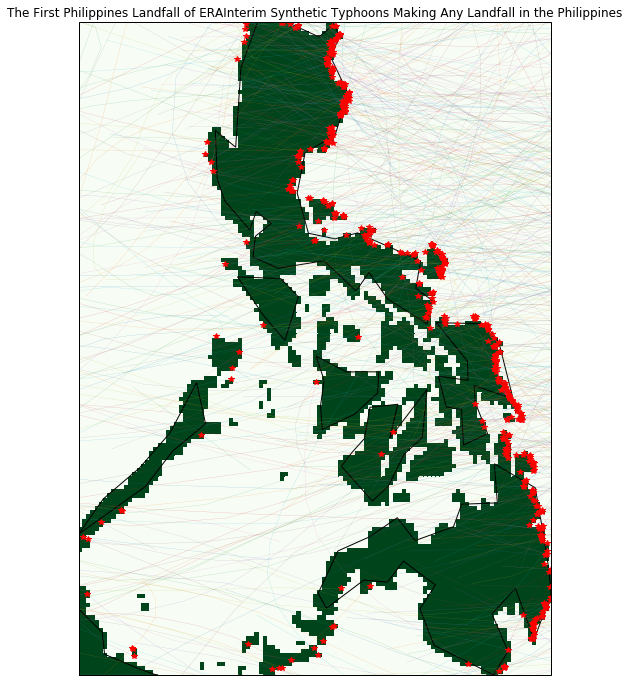

In [17]:
# Plotting tracks and landfall locations

plt.figure(figsize=(16, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(llon,llat,ldmask,cmap=plt.cm.Greens)

for n in range(np.shape(lon)[1]):
    plt.plot(lon[:,n],lat[:,n],linewidth=0.25,alpha=0.4)
    i = iTlandfall_first_phi[n]
    plt.plot(lon[i,n],lat[i,n],'*',color='r')

ax.set_extent([lonmin,lonmax,latmin,latmax])
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title('The First Philippines Landfall of ERAInterim Synthetic Typhoons Making Any Landfall in the Philippines')

Text(0.5, 1.0, 'ERAInterim Synthetic Typhoons Making First Landfall in the Philippines')

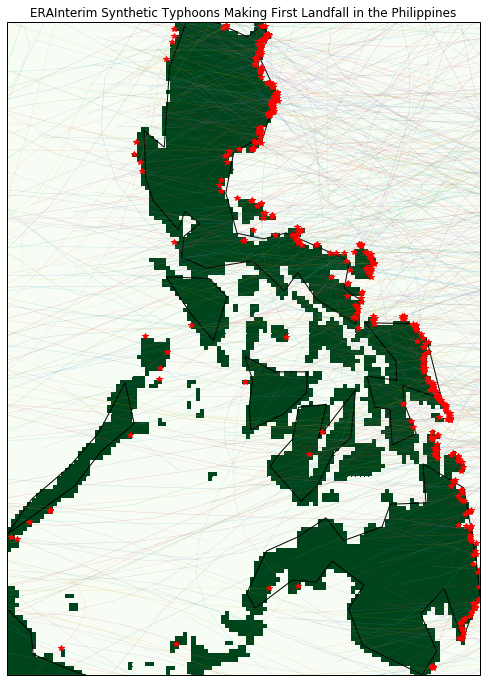

In [18]:
# Plotting tracks and first landfall locations

plt.figure(figsize=(16, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(llon,llat,ldmask,cmap=plt.cm.Greens)

for n in range(np.shape(nSlandfall_first)[0]):
    nS = nSlandfall_first[n]
    plt.plot(lon[:,nS],lat[:,nS],linewidth=0.25,alpha=0.4)
    iT = iTlandfall_first[n]
    plt.plot(lon[iT,nS],lat[iT,nS],'*',color='r')

ax.set_extent([lonmin,lonmax,latmin,latmax])
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title('ERAInterim Synthetic Typhoons Making First Landfall in the Philippines')

In [19]:
# For each storm select time points of landfall, including possibility for second landfall and potential overlap
# iTlandfall_forwindfield_phi

days_before_landfall = 1
days_post_landfall = 1
timesteps_before_landfall = days_before_landfall*4*24 # 4 15-min increments per hour, 24 hours per day
timesteps_post_landfall = days_post_landfall*4*24 # 4 15-min increments per hour, 24 hours per day

iTlandfall_forwindfield_phi = []
nSlandfall_forwindfield_phi = []
for i in range(np.shape(lon)[1]):
    nSlandfall_forwindfield_phi.append(i)
    indices_landfalls = np.where(np.array(nSlandfall_all_phi)==i)[0] # different landfalls per storm
    nlandfalls = np.shape(indices_landfalls)[0]
    if nlandfalls == 1:
        iTlandfall = iTlandfall_all_phi[indices_landfalls[0]]
        iT = np.arange(iTlandfall-timesteps_before_landfall,iTlandfall+timesteps_post_landfall+1,1)
        iTlandfall_forwindfield_phi.append(list(iT))
    if nlandfalls > 1:
        iTs = np.array([],dtype=int)
        for ii in indices_landfalls:
            iTlandfall = iTlandfall_all_phi[ii]
            iT = np.arange(iTlandfall-timesteps_before_landfall,iTlandfall+timesteps_post_landfall+1,1)
            iTs = np.concatenate((iTs,iT),axis=0)
        iTs = np.unique(iTs) # remove wind field points that repeat
        iTlandfall_forwindfield_phi.append(list(iTs))
    iTlandfall_forwindfield_phi[i] = list(filter(lambda x : x > 0, iTlandfall_forwindfield_phi[i])) # remove negative numbers from list https://www.geeksforgeeks.org/python-remove-negative-elements-in-list/ 
            

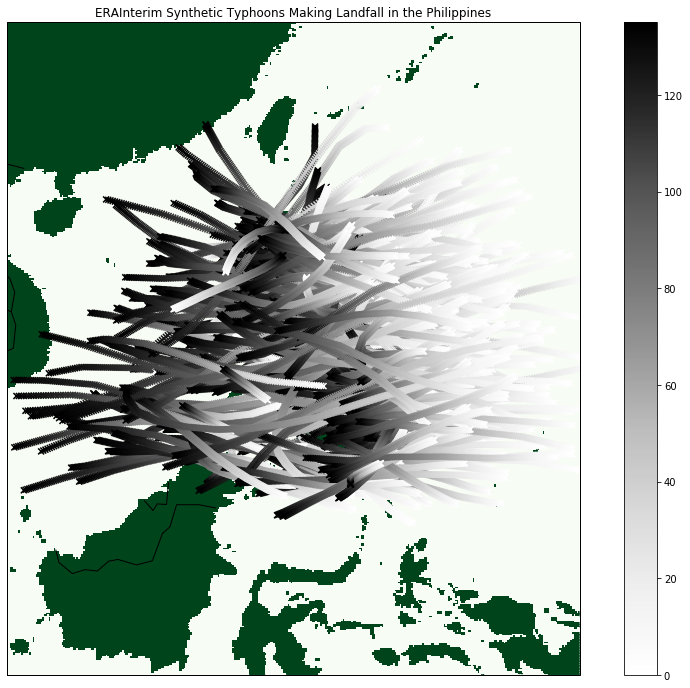

In [20]:
# Plotting tracks 1 day before and after landfall

plt.figure(figsize=(16, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(llon,llat,ldmask,cmap=plt.cm.Greens)

for nS in range(np.shape(lon)[1]):
    iT = iTlandfall_forwindfield_phi[nS]
    plt.scatter(lon[iT,nS],lat[iT,nS],marker='x',c=np.arange(0,len(lon[iT,nS]),1),cmap=plt.cm.Greys)
    #iT = iTlandfall_first[n]
    #plt.plot(lon[iT,nS],lat[iT,nS],'*',color='r')

ax.set_extent([lonmin-10,lonmax+10,latmin-10,latmax+10])
#ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title('ERAInterim Synthetic Typhoons Making Landfall in the Philippines')
plt.colorbar()

In [21]:
# Aggregate only storm points (lat,lon,wspd) where might be making landfall
wspd_landfall = []
lon_landfall = []
lat_landfall = []
days_landfall = []
tr_landfall = []
trDir_landfall = []
year_landfall = []

for nS in range(np.shape(lon)[1]):
    iT = iTlandfall_forwindfield_phi[nS]
    wspd_landfall.append(wspd[:,iT,nS]) #extra dimension = wspd includes 40 ensemble members for each track
    lon_landfall.append(lon[iT,nS])
    lat_landfall.append(lat[iT,nS])
    days_landfall.append(days[iT,nS])
    tr_landfall.append(tr[iT,nS])
    trDir_landfall.append(trDir[iT,nS])

In [22]:
# Distance function
# Center of storm = lat, lon
# Calculate distance between center point and each grid point
# adopted from: https://kite.com/python/answers/how-to-find-the-distance-between-two-lat-long-coordinates-in-python
# radius of earth in km so outputs distance in km

def distancefrompoint(lon, lat, X1, Y1):
    R = 6371.0 #radius of the Earth km

    lat1 = math.radians(lat)
    lon1 = math.radians(lon)
    lat2 = np.radians(Y1)
    lon2 = np.radians(X1)

    # change in coordinates
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Set up function to run wind fields in parallel
# 32 processors total available

# Calculate wind field without adding in asymmetry
def windfield_sym(lon_nS,lat_nS,wspd_nS,rmax_nS,i):
    loni = lon_nS[i]
    lati = lat_nS[i]
    wspdi = wspd_nS[i]
    rmaxi = rmax_nS[i]
    
    # Calculate Willoughby Profile
    radius_max = 500
    radius_precision = 1
    profile = W_profile(lati, rmaxi, wspdi, radius_max, radius_precision)
    radius = np.arange(0,radius_max + radius_precision, radius_precision)
    
    # Create dict look-up table from Willoughby Profile
    wspdlookup = dict(zip(radius, profile))
    
    # Calculate distance from center of storm
    distance = distancefrompoint(loni, lati, X1, Y1) # distance in km
    
    # Round distance values to nearest whole number
    distance = distance.astype(int)

    # Remap radii to windspeed
    wspdmap = np.zeros(np.shape(distance))
    for r in radius:
        wspdmap[np.where(distance == r)] = wspdlookup[r]
        wspdmap[np.where(distance > radius_max)] = 0 # added 10-27-20
    
    return wspdmap


# Calculate wind field with asymmetry:
def windfield(lon_nS,lat_nS,wspd_nS,rmax_nS,tr_nS,trDir_nS,i):
    loni = lon_nS[i]
    lati = lat_nS[i]
    wspdi = wspd_nS[i]
    rmaxi = rmax_nS[i]
    tri = tr_nS[i]
    trDiri = trDir_nS[i]
    
    # Calculate tangential wind
    angle = np.arctan2((Y1-lati),(X1-loni)) - trDiri # define angle relative to track direction 
    vt = -tri*np.cos(np.pi/2 - angle) # calculate tangential wind; remove minus if southern hemisphere
    
    # Calculate Willoughby Profile
    radius_max = 500
    radius_precision = 1
    profile = W_profile(lati, rmaxi, wspdi, radius_max, radius_precision)
    radius = np.arange(0,radius_max + radius_precision, radius_precision)
    
    # Create dict look-up table from Willoughby Profile
    wspdlookup = dict(zip(radius, profile))
    
    # Calculate distance from center of storm
    distance = distancefrompoint(loni, lati, X1, Y1) # distance in km
    
    # Round distance values to nearest whole number
    distance = distance.astype(int)
    
    # Calculate rFactor to modulate track correction
    rFactor = utility.translationspeedFactor(old_div(distance,rmaxi))

    # Remap radii to windspeed
    wspdmap = np.zeros(np.shape(distance))
    for r in radius:
        wspdmap[np.where(distance == r)] = wspdlookup[r]
    
    #Add track direction correction
    wspdmap = wspdmap+(rFactor*vt)
    
    # Set to 0 outside radius_max
    wspdmap[np.where(distance > radius_max)] = 0 # added 10-27-20
    
    #wspdmaps.append(wspdmap)
    
    return wspdmap

In [23]:
# Define x-y grid to put profile on
X = np.arange(116.5,127.6,0.1) #Philippines lon rounded to nearest whole degree (down for min, up for max), plus 0.5deg further for wind radius
Y = np.arange(4.5,19.1,0.1) #Philippines lon rounded to nearest whole degree (down for min, up for max), plus 0.5deg further for wind radius
X1, Y1 = np.meshgrid(X,Y)

# Determine the max iT_lengths
iT_lengths = []
for i in np.arange(0,len(iTlandfall_forwindfield_phi),1):
    iT_lengths.append(len(iTlandfall_forwindfield_phi[i]))
iT_length_max = np.max(iT_lengths)

In [24]:
%%time

# Make sure to delete ens_swaths.nc and wspd_phi_swaths+fileN+.nc before running, otherwise won't pass through properly
direc = '/data2/jbaldwin/WINDFIELDS/ERAInterim_WPC/PHI_SWATHS/'
ensembleNum = dat.ensembleNum
missed_tries = 0
for nS in [0,1,2]: #np.arange(0,len(wspd_landfall)+1,1):
    
    # Info that is consistent across ensemble members
    notnans = ~np.isnan(lon_landfall[nS][:])
    lon_nS = lon_landfall[nS][notnans]
    lat_nS = lat_landfall[nS][notnans]
    days_nS = days_landfall[nS][notnans]
    tr_nS = tr_landfall[nS][notnans]
    trDir_nS = trDir_landfall[nS][notnans]
    swaths = np.zeros([1,len(ensembleNum),len(Y),len(X)])
    
    # Calculate wind swath for each ensemble member
    for ensN in [0,1,2]:#dat.ensembleNum:
    
        print(str(nS)+'-ens#'+str(ensN))
    
        # Find nan points
        notnans_wspd = ~np.isnan(wspd_landfall[nS][ensN,:]) # remove nan points from TC dissipating sooner than 1 day after first landfall
        if np.sum(notnans_wspd) == 0: # if no storm points leave wspdmaps[ensN,...] populated with zeros and move to next
            pass
        
        else:
            # Select data for 1 storm
            wspd_nS_ensN = wspd_landfall[nS][ensN,notnans_wspd]
            lon_nS_ensN = lon_landfall[nS][notnans_wspd]
            lat_nS_ensN = lat_landfall[nS][notnans_wspd]
            tr_nS_ensN = tr_landfall[nS][notnans_wspd]
            trDir_nS_ensN = trDir_landfall[nS][notnans_wspd]
    
            # Calculate radius of maximum wind
            rmax_nS_ensN = utility.knaff15(wspd_nS_ensN*1.944, lat_nS_ensN)  #  wspd should be input in kts, outputs in km
            rmax_min = 20 # minimum rmax used if Knaff15 produces values that are unrealistically small; km
            rmax_nS_ensN[np.where(rmax_nS_ensN<rmax_min)] = rmax_min # 6-12-20: set places with radii less than 0 to 20 km to fix convergence
    
            # Calculate wind fields in parallel
            stormpoints = np.shape(wspd_nS_ensN)[0]  

            wspdmaps = Parallel(n_jobs=3, prefer="threads")(delayed(windfield)(lon_nS_ensN,lat_nS_ensN,wspd_nS_ensN,rmax_nS_ensN,tr_nS_ensN,trDir_nS_ensN,i) for i in range(stormpoints))    
            swaths[0,ensN,:,:] = np.nanmax(wspdmaps, axis = 0) # Calculate swath over windfields; nanmax to ignore timepoints that don't have windfields
                
    # Create swath dataset
    ds_ens = xr.Dataset(
        {"swath": (("nS", "ensembleNum", "lat", "lon"), swaths),
        "days": (("nS","iT"), np.expand_dims(days_nS,axis=0)),
        "year": (("nS"), [year[nS]])},
            coords={
        "nS": np.array([nS]),
        "ensembleNum": ensembleNum,
        "iT": np.arange(len(lon_nS)),
        "lat": Y,
        "lon": X,
        },
        )
            
    #Write each track with its many ensemble members to netcdf        
    filename = 'wspd_phi_swaths_'+fileN+'_'+str(nS)+'.nc'
    ds_ens.to_netcdf(direc+filename,mode='w',unlimited_dims = ["nS"])

0-ens#0
0-ens#1
0-ens#2
1-ens#0
1-ens#1
1-ens#2
2-ens#0
2-ens#1
2-ens#2
CPU times: user 4min 13s, sys: 5.49 s, total: 4min 19s
Wall time: 23.1 s


Text(0, 0.5, 'Run Time [s]')

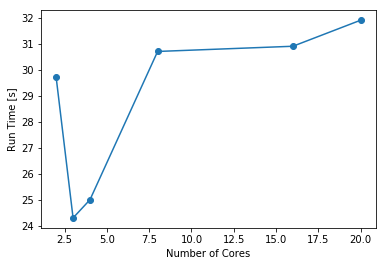

In [280]:
# Optimizing Parallelization
ncores = np.array([2,3,4,8,16,20])
runtime = np.array([29.7,24.3,25,30.7,30.9,31.9])
plt.plot(ncores,runtime,'o-')
plt.xlabel('Number of Cores')
plt.ylabel('Run Time [s]')
plt.title('')
